In [67]:
import serial
import numpy as np
import time
import pandas as pd
import datetime
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import plotly.graph_objects as go

In [253]:
# Initialize serial connection
try:
    ser = serial.Serial('/dev/cu.usbserial-1430', 115200)
except serial.SerialException as e:
    print(f"Failed to connect: {e}")
    raise

# Configuration parameters
run_seconds = 60
samples_per_second = 50
total_samples = int(run_seconds * samples_per_second)

inhale_seconds = 5
exhale_seconds = 5
total_cycle = inhale_seconds + exhale_seconds

field_width = 70
inhale_symbol = "█"
exhale_symbol = "░"

# Pre-calculate the 'breath' symbols for inhale and exhale
inhale_symbol_num = np.ceil((np.sin(np.linspace(-np.pi / 2, np.pi / 2, field_width)) + 1) * field_width / 2)
exhale_symbol_num = inhale_symbol_num[::-1]  # Not directly used, but kept for reference

# Function to read heart rate data
def read_heart_rate(ser):
    try:
        line = ser.readline()
        return int(line.decode('utf-8').strip())
    except ValueError:
        return None

# Function to update the animation display
def update_animation(breath_status, num_symbols):
    if breath_status == "INHALE":
        symbols = inhale_symbol * num_symbols + exhale_symbol * (field_width - num_symbols)
        output_string = f"⬆️ INHALE ⬆️ [{symbols}] ⬆️ INHALE ⬆️"
    elif breath_status == "EXHALE":
        symbols = exhale_symbol * (field_width - num_symbols) + inhale_symbol * num_symbols
        symbols = symbols[::-1]
        output_string = f"⬇️ EXHALE ⬇️ [{symbols}] ⬇️ EXHALE ⬇️"
    else:
        output_string = "Done!"

    clear_output(wait=True)
    display(output_string)

start_time = time.time()
previous_marker_time = -1
breath_status = "INHALE"
signal_data = []
cycle_number = 0

for _ in range(total_samples):
    current_time = time.time()
    diff_time = current_time - start_time
    cycle_time = diff_time % total_cycle

    if cycle_time < inhale_seconds:
        if breath_status != "INHALE":
            cycle_number += 1
        breath_status = "INHALE"
    else:
        breath_status = "EXHALE"

    signal = read_heart_rate(ser)
    if signal is not None:
        signal_data.append((current_time, signal, f'{breath_status}_{cycle_number}'))
    
    proportion = cycle_time / inhale_seconds if breath_status == "INHALE" else (cycle_time - inhale_seconds) / exhale_seconds
    marker_index = int(proportion * (field_width - 1))
    num_symbols = int(inhale_symbol_num[marker_index]) if breath_status == "INHALE" else field_width - int(inhale_symbol_num[marker_index])
    
    if marker_index != previous_marker_time:
        update_animation(breath_status, num_symbols)
        previous_marker_time = marker_index

update_animation("DONE", 0)
ser.close()

'Done!'

In [268]:
timestamp_now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
signal_filename = 'heart_signal_' + timestamp_now + '.csv'
df = pd.DataFrame(signal_data, columns=['time', 'signal', 'breath_status'])
df['type'] = df.breath_status.apply(lambda x: x.split('_')[0])

peaks, thing = find_peaks(df.signal, height=500, distance=20)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.time, y=df.signal, mode='lines', name='signal'))
fig.add_trace(go.Scatter(x=df.time[peaks], y=df.signal[peaks], mode='markers', marker=dict(color='red'), name='peaks'))

# make x-axis labels count in seconds from the start
fig.update_layout(xaxis=dict(tickmode='linear', tick0=0, dtick=10))
fig.show()


In [267]:
peaks_df = df.iloc[peaks].copy()

# Drop first 2 breaths and make sure we have an even number of breaths
breaths = peaks_df.breath_status.unique()[2:]
if len(breaths) % 2 != 0:
    breaths = breaths[:-1]
peaks_df = peaks_df[peaks_df.breath_status.isin(breaths)]

print(f"Inhales + Exhales Analyzed: {len(breaths)}")

Inhales + Exhales Analyzed: 10


<Axes: >

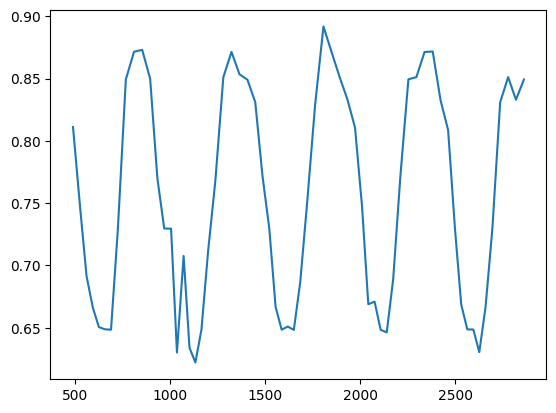

In [260]:
peaks_df.time.diff().plot()

# The E/I ratio
E = sum of the maximum R-R intervals (in s) in each of the expirations.  
I = sum of the minimum R-R intervals (in s) in each of the inspirations.

An E/I ratio <= 1.1 is generally accepted as indicative of total or near-total absence of parasympathetic control of heart rate and suggestive of widespread loss of sympathetic control of other functions.

A ratio >= 1.24 correlates with a likely absence of both cardiac autonomic neuropathy and sensory neuropathy

In [261]:
exhales = peaks_df[peaks_df.type == 'EXHALE']
inhales = peaks_df[peaks_df.type == 'INHALE']

max_exhale_rr_sum = exhales.groupby('breath_status').apply(lambda x: x.time.diff().max()).sum()
min_inhale_rr_sum = inhales.groupby('breath_status').apply(lambda x: x.time.diff().min()).sum()

print(f"Sum of Max R-R Exhale Time: {max_exhale_rr_sum:.4f} seconds")
print(f"Sum of Min R-R Inhale Time: {min_inhale_rr_sum:.4f} seconds")
print(f"E/I Ratio: {max_exhale_rr_sum / min_inhale_rr_sum:.2f}")

Sum of Max R-R Exhale Time: 4.3591 seconds
Sum of Min R-R Inhale Time: 3.1960 seconds
E/I Ratio: 1.36


Average E/I Ratio: 1.62


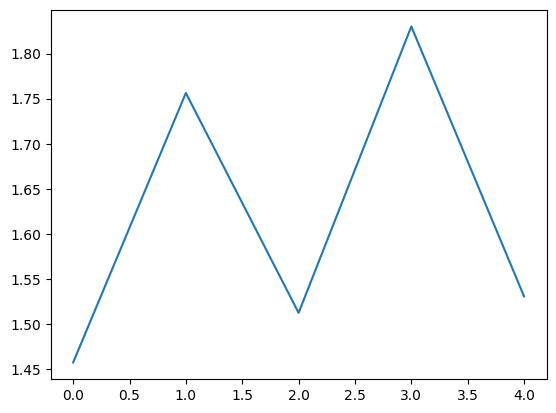

In [237]:
# Get the E/I ratio for each pair of breaths

breath_ratios = []
for i in range(0, len(breaths), 2):
    inhale = peaks_df[peaks_df.breath_status == breaths[i]]
    exhale = peaks_df[peaks_df.breath_status == breaths[i + 1]]
    exhale_time = exhale.time.diff().max()
    inhale_time = inhale.time.diff().min()

    breath_ratios.append(exhale_time / inhale_time)

print(f"Average E/I Ratio: {np.mean(breath_ratios):.2f}")

# Plot the E/I ratio for each pair of breaths
plt.plot(breath_ratios)